NOMBRES: Jose Miguel

APELLIDOS: Gonzalez y Gonzalez

CARNE: 20335

FECHA: 8/23/2024

**Ejercicio 1**
Con los datos, cálcule PPMI, pero aplicando Lapace Smoothing.

In [174]:
import numpy as np
import pandas as pd

In [175]:
# Cargar el archivo proporcionado
file_path = './pmi_ejercicio.xlsx'
data = pd.read_excel(file_path)

# Mostrar las primeras filas del archivo para entender su estructura
data.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,NaN,Computer,data,result,pie,sugar
1,Cherry,2,8,9,44260,25
2,Strawberry,0,0,1,5,19
3,Digital,1670,1683,85,5,4
4,Information,3325,3982,378,512,13


In [176]:
# Renombrar columnas para mayor claridad
data.columns = ["Term"] + list(data.iloc[0, 1:])
data = data[1:]

# Convertir los valores numéricos a enteros para realizar los cálculos
for col in data.columns[1:]:
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(0).astype(int)

# Calcular las frecuencias totales por palabra (sumando filas y columnas)
total_word_frequency = data.set_index("Term").sum(axis=1) + data.drop(columns=["Term"]).sum(axis=0)

# Calcular el total de todas las coocurrencias
total_cooccurrences = data.drop(columns=["Term"]).values.sum()

# Calcular la probabilidad conjunta y aplicar Laplace Smoothing
laplace_k = 1  # Smoothing factor
vocab_size = len(total_word_frequency)  # Tamaño del vocabulario

# Crear una matriz de probabilidades suavizadas
ppmi_matrix = pd.DataFrame(index=data["Term"], columns=data.columns[1:])


In [177]:
for term1 in ppmi_matrix.index:
    for term2 in ppmi_matrix.columns:
        cooccurrence = data.loc[data["Term"] == term1, term2].values[0]
        # Probabilidad conjunta suavizada
        p_xy = (cooccurrence + laplace_k) / (total_cooccurrences + laplace_k * vocab_size ** 2)
        # Probabilidad marginales suavizadas
        p_x = (total_word_frequency[term1] + laplace_k * vocab_size) / (total_cooccurrences + laplace_k * vocab_size ** 2)
        p_y = (total_word_frequency[term2] + laplace_k * vocab_size) / (total_cooccurrences + laplace_k * vocab_size ** 2)
        
        # Calcular PMI
        pmi = np.log2(p_xy / (p_x * p_y)) if p_x * p_y > 0 else 0
        
        # Calcular PPMI
        ppmi_matrix.loc[term1, term2] = max(pmi, 0)

# Mostrar el resultado
print(ppmi_matrix)

            Computer data result pie sugar
Term                                      
Cherry             0    0      0   0     0
Strawberry         0    0      0   0     0
Digital            0    0      0   0     0
Information        0    0      0   0     0


**Ejercicio 2**

POC para crear información de entreno

In [178]:
# Librerías que necesitarán
import io
import re
import string
import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard
import datetime

%load_ext tensorboard

SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [179]:
sentence = "The wind crosses the brown land unheard"  # De mis poemas favoritos. The Waste Land de T.S. Eliot
tokens = sentence.lower().split()  # Tokenizar dividiendo la oración en palabras y convirtiendo todo a minúsculas
vocab, index = {}, 1  # Arreglo de vocabulario, empezar el índice en 1
vocab["<pad>"] = 0  # Es importante tener un padding token para que el programa no explote

# Llenar el arreglo para vocabulario
for word in tokens:
    if word not in vocab:
        vocab[word] = index
        index += 1

vocab_size = len(vocab)
example_sequence = [vocab[word] for word in tokens]
window_size = 2

# Generar positive skip-grams
positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
    example_sequence,
    vocabulary_size=vocab_size,
    window_size=window_size,
    negative_samples=0
)

In [180]:
# Resultados
inverse_vocab = {index: token for token, index in vocab.items()}
for target, context in positive_skip_grams[:5]:
    print(f"({target}, {context}): ({inverse_vocab[target]}, {inverse_vocab[context]})")


(5, 6): (land, unheard)
(6, 5): (unheard, land)
(1, 4): (the, brown)
(3, 1): (crosses, the)
(4, 6): (brown, unheard)


In [181]:
target_word, context_word = positive_skip_grams[0]
# Escoger un número para muestras negativas (que no pertenece al contexto)
num_ns = 4  # Número de muestras negativas

context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
    true_classes=context_class,  # Clase que debe ser muestreada como positiva (que pertenece al contexto)
    num_true=1,
    num_sampled=num_ns,
    unique=True,
    range_max=vocab_size,  # [0, vocab_size]
    seed=SEED,
    name="negative_sampling"
)

In [182]:
print(negative_sampling_candidates)
print([inverse_vocab[index.numpy()] for index in negative_sampling_candidates])


tf.Tensor([1 6 2 4], shape=(4,), dtype=int64)
['the', 'unheard', 'wind', 'brown']


In [183]:
sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)  # Función que construye la tabla de muestreo en forma de frecuencias
print(sampling_table)


[0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381]


In [184]:
negative_sampling_candidates = tf.expand_dims(negative_sampling_candidates, 1)  # Se agrega una dimensión para poder concatenar
context = tf.concat([context_class, negative_sampling_candidates], 0)
label = tf.constant([1] + [0] * num_ns, dtype="int64")
target = tf.squeeze(target_word)
context = tf.squeeze(context)
label = tf.squeeze(label)

# ¡Listo! Así se prepara la información para entrenar

In [185]:
# Información a utilizar:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

In [186]:
#Paso 1: cree una funcion que estandarice el texto como ya hemos hecho e incrustela en una capa de Tensorflow (TextVectorization)
from tensorflow.keras.layers import TextVectorization


# Define la función de estandarización personalizada para la capa de vectorización
def custom_standardization(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

# Crear la capa de vectorización
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=250
)

# Descargar y preparar el dataset
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
text_ds = tf.data.TextLineDataset(path_to_file).filter(lambda x: tf.cast(tf.strings.length(x), bool))

# Adaptar la capa con los datos
vectorize_layer.adapt(text_ds.batch(1024))

# Visualizar el texto nuevamente
for line in text_ds.take(5):
    print(line.numpy().decode('utf-8'))

First Citizen:
Before we proceed any further, hear me speak.
All:
Speak, speak.
First Citizen:


In [187]:
vectorize_layer.adapt(text_ds.batch(1024))

In [188]:
def prepare_training_data(sentences, window_size=2, num_ns=4, seed=42):
    tokens = [sentence.lower().split() for sentence in sentences]
    vocab = {word: idx + 1 for idx, word in enumerate(set(sum(tokens, [])))}
    vocab["<pad>"] = 0  # Añadir palabra de padding

    vocab_size = len(vocab) + 1  # Añadir 1 para incluir <pad>
    
    # Convertir sentencias a secuencias de índices
    sequences = [[vocab[word] for word in token_list] for token_list in tokens]

    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    pairs = []
    labels = []

    for sequence in sequences:
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            window_size=window_size,
            negative_samples=0,
            sampling_table=sampling_table
        )

        for target_word, context_word in positive_skip_grams:
            context_class = tf.reshape(tf.constant(context_word, dtype="int64"), (1, 1))
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class,
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size,
                seed=seed,
                name="negative_sampling"
            )

            pairs.append([target_word, context_word])
            labels.append(1)

            for neg_word in negative_sampling_candidates:
                pairs.append([target_word, neg_word.numpy()])
                labels.append(0)

    return pairs, labels, vocab_size


In [189]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
# Vectorize the data in text_ds.
text_vector_ds = text_ds.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()
sequences = list(text_vector_ds.as_numpy_iterator())

In [190]:
#El siguiente codigo es el modelo Word2Vec usando lo que ya han hecho. Sin embargo, deben agregar la metrica de similitud que vimos en clase, a la cual deben llamar dots
class Word2Vec(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim):
    super(Word2Vec, self).__init__()
    self.target_embedding = layers.Embedding(vocab_size,
                                      embedding_dim,
                                      name="w2v_embedding")
    self.context_embedding = layers.Embedding(vocab_size,
                                       embedding_dim)

  def call(self, pair):
    target, context = pair
    # target: (batch, dummy?)  # The dummy axis doesn't exist in TF2.7+
    # context: (batch, context)
    if len(target.shape) == 2:
      target = tf.squeeze(target, axis=1)
    # target: (batch,)
    word_emb = self.target_embedding(target)
    # word_emb: (batch, embed)
    context_emb = self.context_embedding(context)


    # dots: (batch, context)
    dots = tf.einsum('be,be->b', word_emb, context_emb)  
    return dots

In [191]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
import numpy as np
import matplotlib.pyplot as plt

# 1000 oraciones porque el dataset es muy grande
max_sentences = 1000  
sentences = []
for idx, line in enumerate(text_ds):
    if idx < max_sentences:
        sentences.append(line.numpy().decode('utf-8'))
    else:
        break

# Preparar los datos
pairs, labels, vocab_size = prepare_training_data(sentences, window_size=2, num_ns=4, seed=42)
pairs = np.array(pairs)
labels = np.array(labels)

# Crear el dataset de TensorFlow
dataset = tf.data.Dataset.from_tensor_slices(((pairs[:, 0], pairs[:, 1]), labels))
dataset = dataset.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)

# Dividir el dataset en entrenamiento y validación
dataset_size = len(pairs)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Dividir los datos en arrays de entrenamiento y validación
train_pairs = pairs[:train_size]
train_labels = labels[:train_size]
val_pairs = pairs[train_size:]
val_labels = labels[train_size:]

# Crear los datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices(((train_pairs[:, 0], train_pairs[:, 1]), train_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices(((val_pairs[:, 0], val_pairs[:, 1]), val_labels)).batch(32).prefetch(tf.data.AUTOTUNE)



In [192]:
tensorboard_callback = TensorBoard(log_dir="./")

# Crear el modelo
model = Word2Vec(
    vocab_size, 
    embedding_dim=128
)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=[BinaryAccuracy(name='accuracy')])

# Entrenar el modelo
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[tensorboard_callback])


Epoch 1/10


616/616 [==============================] - 5s 7ms/step - loss: 0.6504 - accuracy: 0.8029 - val_loss: 0.5494 - val_accuracy: 0.8212
Epoch 2/10
616/616 [==============================] - 5s 7ms/step - loss: 0.4408 - accuracy: 0.8429 - val_loss: 0.4616 - val_accuracy: 0.8390
Epoch 3/10
616/616 [==============================] - 5s 7ms/step - loss: 0.2960 - accuracy: 0.8906 - val_loss: 0.4606 - val_accuracy: 0.8376
Epoch 4/10
616/616 [==============================] - 5s 7ms/step - loss: 0.2311 - accuracy: 0.9089 - val_loss: 0.4727 - val_accuracy: 0.8382
Epoch 5/10
616/616 [==============================] - 4s 7ms/step - loss: 0.1938 - accuracy: 0.9198 - val_loss: 0.4847 - val_accuracy: 0.8384
Epoch 6/10
616/616 [==============================] - 4s 7ms/step - loss: 0.1641 - accuracy: 0.9301 - val_loss: 0.4968 - val_accuracy: 0.8380
Epoch 7/10
616/616 [==============================] - 5s 7ms/step - loss: 0.1377 - accuracy: 0.9420 - val_loss: 0.5101 - val_accuracy: 0.8370
Epoch 8/10
616/61

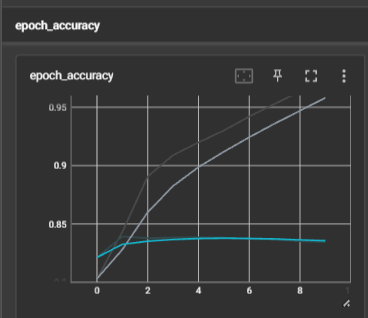

In [195]:
from IPython.display import Image
Image("./epoch_accuracy.png")


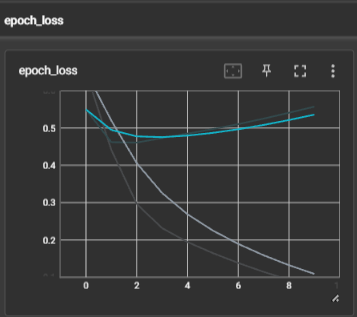

In [196]:
Image("./epoch_loss.png")